In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

import timm
from fastkaggle import *


## Getting set up

In [2]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
path

Path('paddy-disease-classification')

In [4]:
from fastai.vision.all import *
set_seed(42) # For reproducibility

path.ls() # Quick look at the types of data given

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

## Looking at the data

In [5]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


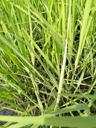

In [6]:
img = PILImage.create(files[0]) # Getting the first image to get an idea of what the images look like
print(img.size)
img.to_thumb(128)

In [7]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

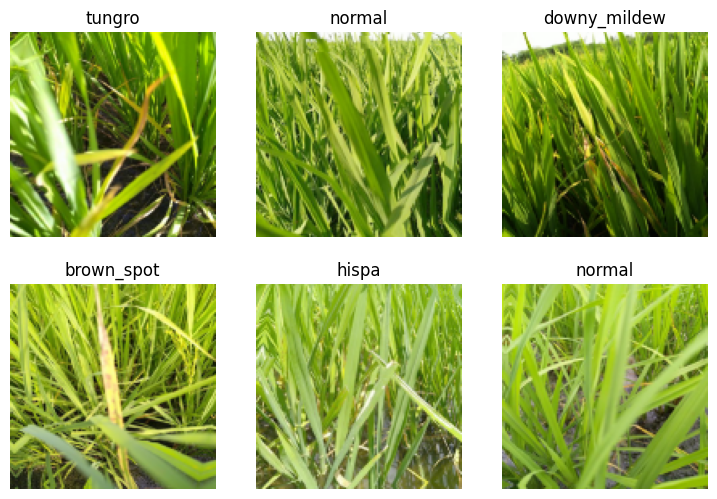

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'), # Making sure all images are of the same size, since some are different based on above cell
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## Our first model

In [9]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jared\.cache\huggingface\hub\models--timm--resnet26d.bt_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

SuggestedLRs(valley=0.0008317637839354575, slide=0.001737800776027143)

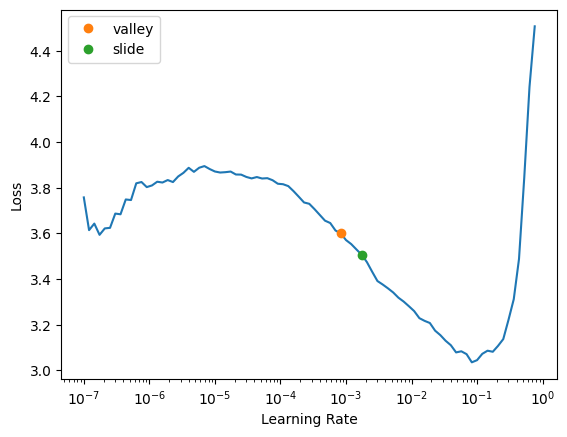

In [10]:
learn.lr_find(suggest_funcs=(valley, slide))

In [11]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.794927,1.330628,0.412782,00:54


epoch,train_loss,valid_loss,error_rate,time
0,1.151180,0.795100,0.260452,00:56
1,0.783998,0.492074,0.162422,00:55
2,0.555008,0.415978,0.129745,00:55


## Submitting to Kaggle

In [12]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [13]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [14]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True) # with_decoded=True to get the class with the highest probability, rather than get the probability of every possible class
idxs 

c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


tensor([7, 8, 4,  ..., 8, 1, 5])

In [15]:
dls.vocab # See what the mapping of the classes to the indices are

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [16]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping) # Pass a dictionary to map function, runs faster than passing a function
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [18]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)

### Creating and submitting a CSV to the competition

In [19]:
# For submitting to competition on Kaggle

if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 73.4k/73.4k [00:00<00:00, 86.8kB/s]


### Creating and pushing a new notebook to Kaggle

In [ ]:
# For pushing new notebook to Kaggle

if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)